In [16]:
import itertools
import pandas as pd
import numpy as np
import requests
import json
import wquantiles
import os

os.chdir('C:/Working/econ_data/micro/')

In [17]:
# Identify which columns to keep from the full CPS
cols = ['year', 'female', 'age', 'educ', 'empl', 'orgwgt', 'weekpay', 'uhourse']
gender = [('Male', 0), ('Female', 1)]
years = range(1979, 2018) # Year range, ending year add one. 
# Age groups (110 used just as max value)
ages = [(16, 24), (25, 34), (35, 44), (45, 54), (55, 64), (65, 110), 
        (16, 110), (25, 54)]
# Education level
educs = [['LTHS'], ['HS'], ['Some college'], ['College'], ['Advanced'], 
         ['LTHS', 'HS'], ['College', 'Advanced']]
# CPI series
cpi = pd.read_csv('cpi_u_rs.csv').set_index('Year')

In [18]:
%%time
data = pd.DataFrame()
demog = pd.DataFrame()
for y in years:
    df = pd.read_stata('data/cepr_org_{}.dta'.format(y), columns=cols)
    tot_pop = df['orgwgt'].sum()
    for args in itertools.product(gender, ages, educs):
        age = '-'.join(str(arg) for arg in args[1])
        if args[1][1] == 110: age = '{}+'.format(args[1][0])
        cname = '{}: {}: {}'.format(args[0][0], age, ' or '.join(args[2]))
        dft = df[(df['age'] >= args[1][0]) & (df['age'] <= args[1][1]) &
                 (df['female'] == args[0][1]) & (df['educ'].isin(args[2]))] 
        demog.set_value(y, cname, (dft['orgwgt'].sum() / tot_pop) * 100)
        dft = dft[(dft['orgwgt'] > 0) & (dft['empl'].notnull())]
        # Calculate employment-population ratio
        epop = np.average(dft['empl'].astype(float), weights=dft['orgwgt']) * 100
        dft = dft[(dft['weekpay'] > 0) & (dft['uhourse'] > 34)]
        # Calculate median wage (nominal and then real)
        mw = round(wquantiles.median(dft['weekpay'], dft['orgwgt']), 2)
        rw = mw * cpi.iloc[-1].values[0] / cpi.loc[y].values[0]
        # Add the epop and median wage to data 
        data.set_value(y, '{}: EPOP'.format(cname), epop)
        data.set_value(y, '{}: median nominal wage'.format(cname), mw)
        data.set_value(y, '{}: median real wage'.format(cname), rw)

Wall time: 1min 45s


In [19]:
st = pd.DataFrame()
sdates = [(1979, 1988), (1988, 2000), (2000, 2015), 
          (2015, 2017), (1979, 2017)]
for args in itertools.product(data.iteritems(), sdates):
    srange = '-'.join(str(arg) for arg in args[1])
    # Calculate mean value for years in each sdate_range
    mean = args[0][1].loc[args[1][0]: args[1][1]].mean()
    # Calculate percentage point change from start to end
    ch = args[0][1].loc[args[1][1]] - args[0][1].loc[args[1][0]]
    # Add mean and change to summary table
    st.set_value(args[0][0], srange+' Mean', mean)
    st.set_value(args[0][0], srange+' Change', ch)

In [20]:
for name, table in [('data', data), ('demog', demog), ('summary_table', st)]:
    table.to_csv('results/EPOPS_{}.csv'.format(name))

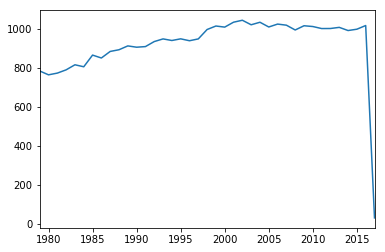

In [21]:
%matplotlib inline
data['Female: 25-54: College: median real wage'].plot()

In [23]:
dft

,year,female,age,educ,empl,orgwgt,weekpay,uhourse
5,2017,1.0,49,College,1.0,61993609,1153.84,40
7,2017,1.0,26,College,1.0,65704751,300.00,40
11,2017,1.0,43,College,1.0,73866148,576.92,40
204,2017,1.0,26,College,1.0,74231127,1490.40,40
214,2017,1.0,44,Advanced,1.0,73269700,1336.00,40
229,2017,1.0,37,Advanced,1.0,59485906,961.00,40
251,2017,1.0,39,College,1.0,59485906,1400.00,40
286,2017,1.0,47,Advanced,1.0,57741979,1346.00,40
293,2017,1.0,40,Advanced,1.0,73269700,1153.84,40
380,2017,1.0,52,Advanced,1.0,65532262,961.53,40
